#### Libraries

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg
import numpy as np
from numpy import expand_dims
import argparse
import os
import glob
import xmltodict
import xml.etree.ElementTree as ET
import xml.etree.ElementTree as ET # copy of xml
from xml.etree.ElementTree import parse
import cv2
from skimage import io
from scipy.signal import convolve2d
from PIL import Image  
import PIL 
import urllib
from urllib.request import urlopen
from typing import Tuple, List, Dict
from bs4 import BeautifulSoup
import requests
from io import BytesIO
from keras.applications import MobileNetV2
from keras import layers
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras import models
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.preprocessing.image import array_to_img
# from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator # load the image
from keras.utils.image_utils import load_img
from keras.utils.image_utils import img_to_array
from keras.utils import to_categorical
from keras import backend as K
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report
import seaborn as sns 

##### Warnings #####

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Data preprocessing

#### URLs for images and annotations

In [4]:
prefix_url_imgs = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/images/"
number_of_imgs = 766 # +1 to include last one (765)

list_imgs = []

for i in range(0, number_of_imgs):
    i = str(i)
    var_imgs = "BikesHelmets" + i + ".png"
    var_imgs_url = prefix_url_imgs + var_imgs
    list_imgs.append(var_imgs_url)

In [5]:
prefix_url_xml = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/annotations/"
number_of_annt = 766 # +1 to include last one (765)

list_annotations= []

for i in range(0, number_of_annt):
    i = str(i)
    var_annt = "BikesHelmets" + i + ".xml"
    var_annt_url = prefix_url_xml + var_annt
    list_annotations.append(var_annt_url)

### Augmentantion functions

In [6]:
def picture_zoom(image):
   # to array
   array = expand_dims(image[1], 0)
   # create image data augmentation generator
   datagen_zoom= ImageDataGenerator(zoom_range=[0.8,1.5])
   # prepare iterator
   it_zoom = datagen_zoom.flow(array, batch_size=1)
   # generate batch of images
   batch_zoom = it_zoom.next()
   # convert to unsigned integers for viewing
   image_zoom = batch_zoom[0].astype('uint64')
   # returning list
   list = [image[0], image_zoom, image[2], image[3]]
   return list

In [7]:
def picture_rotation(image):
    # to array
    array = expand_dims(image[1], 0)
    # ImageDataGenerator rotation
    datagen_rotation=ImageDataGenerator(rotation_range=45, fill_mode='nearest')
    # prepare iterator
    it_rotation = datagen_rotation.flow(array, batch_size=1)
    # generate batch of images
    batch_rotation = it_rotation.next()
    # convert to unsigned integers for viewing
    image_rotation = batch_rotation[0].astype('uint64')
    # plot raw pixel 
    img_rotation=plt.imshow(image_rotation, interpolation ='None', filternorm=True) #spline36, antialiased
    # returning list
    list = [image[0], image_rotation, image[2], image[3]]
    return list

In [8]:
def picture_brightness(image):
    # to array
    array = expand_dims(image[1], 0)
    # create image data augmentation generator
    datagen_brightness = ImageDataGenerator(brightness_range=[0.2,1.0])
    # prepare iterator
    it_brightness = datagen_brightness.flow(array, batch_size=1)
    # generate batch of images
    batch_zoom = it_brightness.next()
    # convert to unsigned integers for viewing
    image_brightness = batch_zoom[0].astype('uint64')
    # plot raw pixel 
    img_brightness=plt.imshow(image_brightness, interpolation ='None')
    # returning list
    list = [image[0], image_brightness, image[2], image[3]]
    return list

### Images load
* Retrieving and labelling images from XML annotations
* No bounding box, multiple faces per image
* For images with multiple people, if and only if all people wear helmet the label would be 1, otherwise label would be 0.

In [9]:
full_imgs = []

for xml_path in list_annotations:
    try:    
        with urlopen(xml_path) as my_xml:
        
            xmld = xmltodict.parse(my_xml)
            tags = xmld['annotation']

            a = 0
            img_path = prefix_url_imgs + tags['filename']
            img_url = requests.get(img_path)
            img_temp = Image.open(BytesIO(img_url.content))
            resized = img_temp.resize((224,224)) # resize all images to 224x224
            image = cv2.cvtColor(np.array(resized), cv2.INPAINT_TELEA)
            
            if 'object' in tags:

                if isinstance(tags['object'], list):
                    for i in tags['object']:
                        if i['name'] == 'With Helmet':
                            a =+1
                        else:
                            a =+0
                    if a > 0 :
                        full_imgs.append([tags['filename'], image, 1, img_path])
                    else :
                        full_imgs.append([tags['filename'], image, 0, img_path])
                
                if isinstance(tags['object'], dict):
                    if tags['object']['name'] == 'With Helmet':
                        full_imgs.append([tags['filename'], image, 1, img_path])
                    else:
                        full_imgs.append([tags['filename'], image, 0, img_path])
            else:
                pass
    except:
        pass

* Augment full images

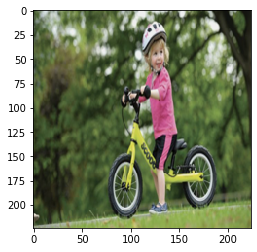

In [10]:
# Augmentantion of full images
augm_full_imgs = []
for i in range(0, len(full_imgs)):
    augm_full_imgs.append(picture_zoom(full_imgs[i]))
    augm_full_imgs.append(picture_rotation(full_imgs[i]))
    augm_full_imgs.append(picture_brightness(full_imgs[i]))

In [11]:
# consolidate initial with augmented images in one list
final_full_imgs = full_imgs + augm_full_imgs

print("Total full images:", len(final_full_imgs))
print("of which initial images:", len(full_imgs))
print("of which augmented images:", len(augm_full_imgs))

Total full images: 3044
of which initial images: 761
of which augmented images: 2283


Text(0, 0.5, 'Labels')

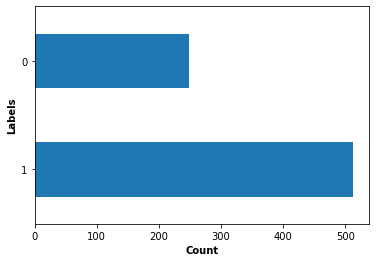

In [12]:
# Converts lists for images names and for the corresponding label names
list1=[]
list2=[]

for i in range(0,len(full_imgs)):
    list1.append(full_imgs[i][0])
    list2.append(full_imgs[i][2])
    
df=pd.DataFrame()
df=df.assign(Images=list1)
df=df.assign(Labels=list2)

df["Labels"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Labels', fontsize = 10, fontweight = 'bold')

* Transform full images to model inputs

In [13]:
# Transforming images in a proper array for model input
full_imgs_array = []
for i in range(0, len(final_full_imgs)):
    full_imgs_array.append(np.array(final_full_imgs[i][1]))
full_imgs_array = np.array(full_imgs_array, dtype='int')

In [14]:
# shape of new array
full_imgs_array.shape

(3044, 224, 224, 3)

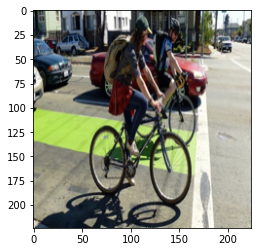

In [15]:
# testing that images appear correctly
plt.imshow(full_imgs_array[714])

In [16]:
# Creating an array with labels
labels_array = []
for i in range(0, len(final_full_imgs)):
    labels_array.append(np.array(final_full_imgs[i][2]))
labels_array = np.array(labels_array, dtype='int')

In [17]:
# Categorically encode the labels
full_imgs_labels = to_categorical(labels_array)

### Data reshaping

In [18]:
def reshape_img_input(x: np.ndarray,
                      img_rows: int = 224,
                      img_cols: int = 224,
                      normalize: bool = True) -> Tuple:
        
    print(f'Original shape of nd-array: {x.shape}')
    
    if K.image_data_format() == 'channels_first':
        
        # the channel dimension goes to the front
        x1 = x.reshape(x.shape[0], 3, img_rows, img_cols)

        input_shape = (3, img_rows, img_cols)

    else:
        # the channel dimension goes to the end. So we end up with the following 4-D tensor
        # (N-samples, Height, Width, N-channels)
        x1 = x.reshape(x.shape[0], img_rows, img_cols, 3)

        input_shape = (img_rows, img_cols, 3)

    x1 = x1.astype('float32')

    if normalize:
        x1 /= 255.
        
    return x1, input_shape

In [19]:
data, input_shape = reshape_img_input(x=full_imgs_array,
                                         img_rows=224, 
                                         img_cols=224,
                                         normalize=True)

Original shape of nd-array: (3044, 224, 224, 3)


### Train, Test & Validation split
* We now split the full dataset into train (75%) and test (25%) sets. 
* The test set is splitted again to test (25%) and validation (75%) sets.
* Random sampling is a very bad option for splitting. So, we tried stratified sampling. 
* This method splits your class proportionally between training and test set. Run oversampling, undersampling or hybrid techniques on training set.

In [110]:
#https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# split into train test sets
from sklearn.model_selection import train_test_split
X_train, X_test_1, y_train, y_test_1 = train_test_split(data, full_imgs_labels,
                                                    stratify=full_imgs_labels, 
                                                    test_size=0.25, random_state=5)

X_test, X_val, y_test, y_val = train_test_split(X_test_1, y_test_1,
                                                    stratify=y_test_1, 
                                                    test_size=0.25, random_state=5)

## Models hyperparameters

#### Universal parameters
* Setting parameters to be used across models.

In [21]:
learning_Rate = 1e-3
num_Epochs = 50
batch_Size = 32
steps_per_Epoch = int(len(X_train) / batch_Size)

### Callbacks

#### Early Stopping
* Before training the network, we define an early stopping criterion, to avoid redundent epochs once the model has already converged.

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 1, restore_best_weights = True)

#### Reduce Learning Rate On Plateau
* We define a ReduceLROnPlateau callback to reduce the learning rate when the metric we chose (val_loss) has stopped improving.

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.1, min_lr = 1e-6)

## Models

### Model 1 - Simple CNN
* https://github.com/mohandandamudi/FaceMaskDetection/blob/master/Face%20Mask%20Detection.ipynb

In [24]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.models import Sequential
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

* Buliding Model 

In [25]:
# Adding model layers
CNN_few_Layers = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(2, activation='softmax')
])
CNN_few_Layers.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 2)                 788546    
                                                                 
Total params: 789,442
Trainable params: 789,442
Non-trainable params: 0
_________________________________________________________________


* Compiling Model

In [26]:
opt = optimizers.Adam(learning_rate=learning_Rate) 
CNN_few_Layers.compile(optimizer=opt, 
                         loss='categorical_crossentropy', 
                         metrics=['accuracy', 'Recall', 'Precision', 'AUC']) #categorical_crossentropy or binary_crossentropy

* Fitting Model

In [29]:
model_1 = CNN_few_Layers.fit(
                    x = X_train,
                    y = y_train,
                    epochs = num_Epochs, # early stopping epoch: 10
                    steps_per_epoch = steps_per_Epoch, 
                    batch_size = batch_Size, 
                    verbose = 1,
                    validation_data = (X_val,y_val),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/5
71/71 [==============================] - 56s 706ms/step - loss: 2.3765 - accuracy: 0.6215 - recall: 0.6215 - precision: 0.6215 - auc: 0.6358 - val_loss: 0.6176 - val_accuracy: 0.6440 - val_recall: 0.6440 - val_precision: 0.6440 - val_auc: 0.7155 - lr: 0.0010
Epoch 2/5
71/71 [==============================] - 78s 1s/step - loss: 0.3906 - accuracy: 0.8410 - recall: 0.8410 - precision: 0.8410 - auc: 0.9173 - val_loss: 0.4429 - val_accuracy: 0.8220 - val_recall: 0.8220 - val_precision: 0.8220 - val_auc: 0.8908 - lr: 0.0010
Epoch 3/5
71/71 [==============================] - 51s 710ms/step - loss: 0.1890 - accuracy: 0.9449 - recall: 0.9449 - precision: 0.9449 - auc: 0.9842 - val_loss: 0.4974 - val_accuracy: 0.8063 - val_recall: 0.8063 - val_precision: 0.8063 - val_auc: 0.8610 - lr: 0.0010
Epoch 4/5
71/71 [==============================] - 72s 1s/step - loss: 0.0976 - accuracy: 0.9769 - recall: 0.9769 - precision: 0.9769 - auc: 0.9946 - val_loss: 0.5058 - val_accuracy: 0.8325 - val_

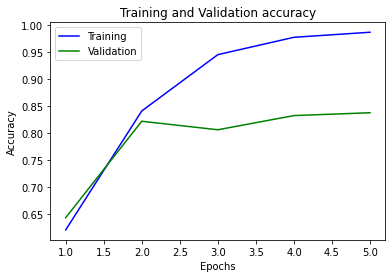

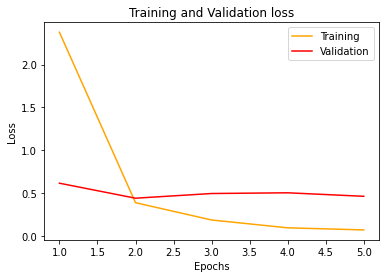

In [30]:
loss = model_1.history['loss']
val_loss = model_1.history['val_loss']
acc = model_1.history['accuracy']
val_acc = model_1.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2 - Custom CNN

* Building Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
CNN_adjusted_v1 = Sequential()
CNN_adjusted_v1.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (224, 224, 3)))
CNN_adjusted_v1.add(MaxPooling2D(pool_size = 2))
CNN_adjusted_v1.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
CNN_adjusted_v1.add(MaxPooling2D(pool_size = 2))
CNN_adjusted_v1.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
CNN_adjusted_v1.add(MaxPooling2D(pool_size = 2))
CNN_adjusted_v1.add(Dropout(0.3))
CNN_adjusted_v1.add(Flatten())
CNN_adjusted_v1.add(Dense(units = 500, activation = 'relu'))
CNN_adjusted_v1.add(Dropout(0.4))
CNN_adjusted_v1.add(Dense(units = 2, activation = 'softmax'))
CNN_adjusted_v1.summary()

* Compiling Model

In [ ]:
opt = optimizers.Adam(learning_rate=learning_Rate) 
CNN_adjusted_v1.compile(optimizer=opt,
                    loss="categorical_crossentropy",
                    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

* Fitting Model

In [ ]:
model_2 = CNN_adjusted_v1.fit(
                    x = X_train,
                    y = y_train,
                    epochs = num_Epochs, #>=30 / Early stopping: 15 epochs
                    steps_per_epoch = steps_per_Epoch, 
                    batch_size = batch_Size,
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks = [early_stopping, lrr]
                    )

In [ ]:
loss = model_2.history['loss']
val_loss = model_2.history['val_loss']
acc = model_2.history['accuracy']
val_acc = model_2.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 3 - Adjusted Custom CNN

In [ ]:
# placeholder for comments regarding differences with model 2

In [ ]:
#Model CNN with RmsProp Optimizer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout

* Building Model

In [ ]:
CNN_adjusted_v2=Sequential()
CNN_adjusted_v2.add(Conv2D(filters = 16, kernel_size = 3, padding='same', activation = 'relu', input_shape = (224, 224, 3)))
CNN_adjusted_v2.add(MaxPooling2D(pool_size = 2))
CNN_adjusted_v2.add(Conv2D(filters = 32, kernel_size=3,padding='same', activation='relu'))
CNN_adjusted_v2.add(MaxPooling2D(pool_size = 2))
CNN_adjusted_v2.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu'))
CNN_adjusted_v2.add(MaxPooling2D(pool_size = 2))
CNN_adjusted_v2.add(Conv2D(filters = 128, kernel_size = 3, padding='same', activation = 'relu'))
CNN_adjusted_v2.add(MaxPooling2D(pool_size = 2))
CNN_adjusted_v2.add(Flatten())
CNN_adjusted_v2.add(Dense(units = 500, activation = 'relu'))
CNN_adjusted_v2.add(Dropout(0.3))
CNN_adjusted_v2.add(Dense(units = 50, activation = 'relu'))
CNN_adjusted_v2.add(Dense(units = 2, activation ='softmax'))
CNN_adjusted_v2.summary()

* Compiling Model

In [ ]:
CNN_adjusted_v2.compile(
    optimizer = "rmsprop",
    loss = "categorical_crossentropy",
    metrics = ['accuracy', 'Recall', 'Precision', 'AUC']
)

* Fitting Model

In [ ]:
model_3 = CNN_adjusted_v2.fit(
                    x = X_train,
                    y = y_train,
                    steps_per_epoch = steps_per_Epoch,
                    epochs = num_Epochs,
                    batch_size = batch_Size,
                    verbose = 1, 
                    shuffle = True,
                    validation_data = (X_val, y_val),
                    callbacks = [early_stopping, lrr]
                )

In [ ]:
loss = model_3.history['loss']
val_loss = model_3.history['val_loss']
acc = model_3.history['accuracy']
val_acc = model_3.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 4 - InceptionV3

In [197]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
import tensorflow as tf
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

* Bulding Model

In [198]:
inceptv3 = InceptionV3(
    weights = "imagenet",
    input_shape = (224, 224, 3),
    include_top = False 
)

for layer in inceptv3.layers:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))
x = inceptv3(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation='softmax')(x)
inception_v3 = Model(inputs, outputs)

inception_v3.summary()

87910968/87910968 [==============================] - 46s 1us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


* Compiling Model

In [ ]:
opt = optimizers.Adam(learning_rate=learning_Rate*10) 
inception_v3.compile(optimizer = opt,
                        loss = "categorical_crossentropy",
                        metrics = ['accuracy', 'Recall', 'Precision', 'AUC'])

* Fitting Model

In [ ]:
model_4 = inception_v3.fit(
                    x = X_train,
                    y = y_train,
                    epochs = num_Epochs,
                    steps_per_epoch = steps_per_Epoch,
                    batch_size = batch_Size,
                    verbose = 1,
                    validation_data = (X_val,y_val),
                    callbacks = [early_stopping, lrr]
                    )

In [ ]:
loss = model_4.history['loss']
val_loss = model_4.history['val_loss']
acc = model_4.history['accuracy']
val_acc = model_4.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Fine-tuning of the entire model
* Now that InceptionV3 model has converged on the new data, we unfreeze all the layers and retrain the whole model end-to-end with a very low learning rate.
* We use a very low learning rate at this stage, because we are training a much larger model than in the first round of training, on a dataset that is very small. So we are at risk of overfitting very quickly if we apply large weight updates. <br>
Source: https://www.tensorflow.org/guide/keras/transfer_learning#do_a_round_of_fine-tuning_of_the_entire_model

In [ ]:
inceptv3.trainable = True
inception_v3.summary()

opt = optimizers.Adam(learning_rate=learning_Rate/100) #very low learning rate: 1e-5
inception_v3.compile(optimizer = opt,
                        loss = "categorical_crossentropy",
                        metrics = ['accuracy', 'Recall', 'Precision', 'AUC'])

In [ ]:
model_4_v2 = inception_v3.fit(
                    x = X_train,
                    y = y_train,
                    epochs = int(num_Epochs/5), #for 10 epochs only
                    steps_per_epoch = steps_per_Epoch,
                    batch_size = batch_Size,
                    verbose = 1,
                    validation_data = (X_val,y_val),
                    )

### Model 5 - MobileNet2

* Building Model

In [ ]:
# transform to appropriate MobileNet2 input / normalize to (-1, 1)
data_mn2 = tf.keras.applications.mobilenet_v2.preprocess_input(full_imgs_array)

In [ ]:
# split into train test sets
X_train_mn, X_test_1_mn, y_train_mn, y_test_1_mn = train_test_split(data_mn2, full_imgs_labels,
                                                    stratify = full_imgs_labels, 
                                                    test_size = 0.25, random_state = 5)

X_test_mn, X_val_mn, y_test_mn, y_val_mn = train_test_split(X_test_1_mn, y_test_1_mn,
                                                    stratify = y_test_1_mn, 
                                                    test_size = 0.25, random_state = 5)

In [ ]:
mob_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

for layer in mob_net.layers:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))
x = mob_net(inputs, training=False) # added
x = GlobalAveragePooling2D()(x)
#x = Dense(1024, activation='relu')(x) #dense layer 2
#x = Dense(512, activation='relu')(x) #dense layer 3
preds = Dense(2, activation='softmax')(x) #final layer with softmax activation
mob_net2 = Model(inputs, preds)

mob_net2.summary()

In [ ]:
# for i,layer in enumerate(mob_net2.layers):
#   print(i,layer.name)

* Compiling Model

In [ ]:
opt = optimizers.Adam(learning_rate=learning_Rate*10) 
mob_net2.compile(optimizer = opt,
              loss='categorical_crossentropy',
              metrics = ['accuracy', 'Recall', 'Precision', 'AUC'])

* Fitting Model

In [ ]:
model_5 = mob_net2.fit(
                    x = X_train_mn,
                    y = y_train_mn,
                    epochs = num_Epochs,
                    steps_per_epoch = steps_per_Epoch,
                    batch_size = batch_Size, 
                    verbose = 1,
                    validation_data = (X_val_mn, y_val_mn),
                    callbacks = [early_stopping, lrr]
                    )

In [ ]:
loss = model_5.history['loss']
val_loss = model_5.history['val_loss']
acc = model_5.history['accuracy']
val_acc = model_5.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Fine-tuning of the entire model

In [ ]:
mob_net.trainable = True
mob_net2.summary()

opt = optimizers.Adam(learning_rate=learning_Rate/100) #very low learning rate: 1e-5
mob_net2.compile(optimizer = opt,
                        loss = "categorical_crossentropy",
                        metrics = ['accuracy', 'Recall', 'Precision', 'AUC'])

In [ ]:
model_5_v2 = mob_net2.fit(
                    x = X_train_mn,
                    y = y_train_mn,
                    epochs = int(num_Epochs/5), #for 10 epochs only
                    steps_per_epoch = steps_per_Epoch,
                    batch_size = batch_Size,
                    verbose = 1,
                    validation_data = (X_val_mn, y_val_mn),
                    )

### Saving best model's weights

In [ ]:
best_model = inception_v3
best_model.save_weights(r'.\team_quebec_results\best_model_weights')

## Models Comparison 


### Functions for plots

In [ ]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    
    """Evaluation function
    Prints Classification reports and confusion matrix
    """
    cm = confusion_matrix(y, y_hat)
#     precision = precision_score(y, y_hat)
#     recall = recall_score(y, y_hat)
#     accuracy = accuracy_score(y,y_hat)
#     f1 = f1_score(y,y_hat)
#     report = classification_report(y,y_hat)
#     print(report)
#     print('Recall: ', recall)
#     print('Accuracy: ', accuracy)
#     print('Precision: ', precision)
#     print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

In [ ]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

### Compare classifiers

In [ ]:
import pandas
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, log_loss
from sklearn.datasets import make_classification
from sklearn import model_selection

In [ ]:
# * Precision: The model precision score measures the proportion of positively predicted labels that are actually correct. Precision is also known as the positive predictive value. Precision Score = TP / (FP + TP)
# * Accuracy: Tells us how often we can expect our machine learning model will correctly predict an outcome out of the total number of times it made predictions.  Accuracy Score = (TP + TN)/ (TP + FN + TN + FP)
# * Recall score is used to measure the model performance in terms of measuring the count of true positives in a correct manner out of all the actual positive values.
# * F1-score is harmonic mean of precision and recall score and is used as a metrics in the scenarios where choosing either of precision or recall score can result in compromise in terms of model giving high false positives and false negatives respectively. 
#   F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)

In [ ]:
classifiers = [CNN_few_Layers,
    CNN_adjusted_v1,
    CNN_adjusted_v2,
    inception_v3,
    mob_net2
    ]
name_of_model = ["CNN_few_Layers",
    "CNN_adjusted_v1",
    "CNN_adjusted_v2",
    "inception_v3",
    "mob_net2"
    ]

In [ ]:
# Logging for Visual Comparison
log_cols = ["Classifier", "Accuracy", "Precision", "Recall", "F1", "AUC"]

log = pd.DataFrame(columns=log_cols)
i = 0

for clf in classifiers:

    name=name_of_model[i]
    i+=1    

    # if statamenet to use rescaled (-1, 1) test dataset for MobileNet2
    if name == name_of_model[-1]:
        y_true = np.argmax(y_test_mn, axis = 1)[:]
        pred = clf.predict(X_test_mn, verbose = 0) # Predict prob and get Class Indices
        y_pred= np.argmax(pred, axis = 1)[:]
    else:
        # calculate y_pred
        y_true = np.argmax(y_test, axis = 1)[:]
        pred = clf.predict(X_test, verbose = 0) # Predict prob and get Class Indices
        y_pred= np.argmax(pred, axis = 1)[:]

    # calculate accuracy
    acc = accuracy_score(y_pred[:], y_true[:])
    
    # calculate precision	
    pre = precision_score(y_pred[:], y_true[:])

    # calculate Recall	
    rec = recall_score(y_pred[:], y_true[:])

    # calculate F1-score
    f1 = f1_score(y_pred[:], y_true[:])

    # calculate AUC
    auc = roc_auc_score(y_true, y_pred)
    
    # pass them in a dataframe for visualization
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100, f1*100, auc*100]], columns=log_cols)
    log = pd.concat([log, log_entry], axis = 0)
    
    # Print the results
    # print("="*30)   
    # print('**** Results ' + name + '****')
    # print("Accuracy: {:.4%}".format(acc))
    # print("Precision: {:.4%}".format(pre) )
    # print("Recall: {:.4%}".format(rec) )
    # print("F1-score: {:.4%}".format(f1) )
    # print( name + ": ROC AUC: {:.4%}".format(auc))

# print("="*15 + " End " + "="*15)

In [ ]:
round(log.set_index('Classifier').sort_values(by='Accuracy', ascending = False), 1)

### Evaluation Plots

In [ ]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300

In [ ]:
## Accuracy
# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Accuracy %')
plt.title('Accuracy')
plt.show()

## Precision

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=log, color="g")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Precision %')
plt.title('Precision')
plt.show()

## Recall

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log, color='c')

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Recall %')
plt.title('Recall')
plt.show()

## F1

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='F1', y='Classifier', data=log, color="y")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('F1-score %')
plt.title('F1-score')
plt.show()

## AUC
# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='AUC', y='Classifier', data=log, color="r")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Area Under Curve')
plt.title('AUC')
plt.show()

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

df2 = pd.melt(log, value_vars=[ "Accuracy", "Precision", "Recall", "F1", "AUC"], id_vars="Classifier")

#sns.set(style="ticks")

g = sns.catplot(data=df2,
                   kind="bar",
                   col="variable", # we have 1 plot per variable, forming 1 line and 5 columns (5 different variables)
                   x="Classifier", # in each plot the x-axis will be the name
                   y="value", # the height of the bar
                   col_wrap=3,# we actually want your line of plots to contain 3 plots maximum 
                   palette="mako", #Set2,Paired
                  )

# adding labels to bars
for ax in g.axes.ravel():
    for c in ax.containers:
        labels = [f'{(v.get_height()):.1f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)
 
g.set_xticklabels(fontsize=10, rotation=25) # rotate the labels so they don't overlap
plt.tight_layout() # fit everything into the figure


### Plot Area Under Curve

In [ ]:
from sklearn import metrics

i=0
labels=[]

# Figure Size
plt.subplots(figsize =(10, 5))
# Add x, y gridlines
plt.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 0.5,
        alpha = 0.2)

# Plot models' ROC curves
for clf in classifiers:
  name = name_of_model[i]
  i+=1
  
  # if statement to select scaled data(-1, 1) for MobileNet2
  if name == name_of_model[-1]:
    pred = clf.predict(X_test_mn, verbose = 0).ravel() # Predict prob and get Class Indices
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test_mn.ravel(), pred) # Calculate ROC curves
  else:
    pred = clf.predict(X_test, verbose = 0).ravel()
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test.ravel(), pred)
  
  # plot the roc curve of the model
  plt.plot(ns_fpr, ns_tpr, linestyle='-', label=name)
  labels.append(name)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(labels, 
          columnspacing=1.0, 
          labelspacing=0.0,
          handletextpad=0.0, 
          handlelength=1.5,
          fancybox=True,
          shadow=True)
   
# show the plot
plt.show()

### Accuracy vs False Negative Rate

In [ ]:
i=0
labels=[]

# Figure Size
plt.subplots(figsize =(10, 5))

# Add x, y gridlines
plt.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 0.5,
        alpha = 0.2)

# Plot several different AUC
for clf in classifiers:
  name = name_of_model[i]
  i+=1    
  
  # if statement to select scaled data(-1, 1) for MobileNet2
  if name == name_of_model[-1]:
    y_true = np.argmax(y_test_mn, axis = 1)[:]
    pred = clf.predict(X_test_mn, verbose = 0) # Predict prob and get Class Indices
    y_pred= np.argmax(pred, axis = 1)[:]
  else:
    y_true = np.argmax(y_test, axis = 1)[:]
    pred = clf.predict(X_test, verbose = 0)
    y_pred= np.argmax(pred, axis = 1)[:]
  
  cf = confusion_matrix(y_true, y_pred)
  fpr = (cf[1][0] / ( cf[1][0] + cf[0][1] ))*100
  acc = log.loc[log['Classifier']==name,'Accuracy']
  
  plt.scatter(fpr, acc)#, label=name)
  #labels.append(name)

  plt.annotate(name, (fpr-0.6, acc+0.2))
  
# axis labels
plt.xlabel('False Positive Rate%')
plt.ylabel('Accuracy%')
#plt.legend(labels, 
          # columnspacing=1.0, 
          # labelspacing=0.0,
          # handletextpad=0.0, 
          # handlelength=1.5,
          # fancybox=True,
          # shadow=True)
   
# show the plot
plt.show()

### Showcase

In [ ]:
# placeholder to display images and relevant predictions

## Appendix

### Images with bounding box on head

In [189]:
cropped_imgs = []

for xml_path in list_annotations:
    try:    
        with urlopen(xml_path) as my_xml:
        
            xmld = xmltodict.parse(my_xml)
            tags = xmld['annotation']

            img_path = prefix_url_imgs + tags['filename']
            img_url = requests.get(img_path)
            img_temp = Image.open(BytesIO(img_url.content))
            image = cv2.cvtColor(np.array(img_temp), cv2.INPAINT_TELEA)
            helmet = np.zeros(image.shape, dtype = 'int32')

            if 'object' in tags:

                if isinstance(tags['object'], list):
                    for i in tags['object']:
                        xmin = int(i['bndbox']['xmin'])
                        ymin = int(i['bndbox']['ymin'])
                        xmax = int(i['bndbox']['xmax'])
                        ymax = int(i['bndbox']['ymax'])
                        if i['name'] == 'With Helmet':
                            helmet = cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (0,255,0), -1)
                            result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3) #with helmet -> 1
                            cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 1, img_path])
                            #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                            
                        else:
                            cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (255,0,0), -1)
                            result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                            cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 0, img_path]) #without helmet -> 0
                            
                            #plt.imsave(os.path.join('results', tags['filename']), result)
                    #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                if isinstance(tags['object'], dict):
                    xmin = int(tags['object']['bndbox']['xmin'])
                    ymin = int(tags['object']['bndbox']['ymin'])
                    xmax = int(tags['object']['bndbox']['xmax'])
                    ymax = int(tags['object']['bndbox']['ymax'])
                    if tags['object']['name'] == 'With Helmet':
                        cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (0,255,0), -1)
                        result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                        cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 1, img_path]) #with helmet -> 1
                        #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                    else:
                        cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (255,0,0), -1)
                        result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                        cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 0, img_path]) #without helmet -> 0
                    # plt.imsave(os.path.join('results', tags['filename']), result)
                    #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
            else:
                pass
    except:
        pass

### Data preprocessing

#### Data reshaping

In [190]:
from tensorflow.keras.preprocessing.image import array_to_img
all_cropped_imgs_v2 = []
for i in range(1, len(cropped_imgs)):
    try:
        img_temp = array_to_img(cropped_imgs[i][1])
        resized = img_temp.resize((120,120)) # resize all images to 40x40
        image = cv2.cvtColor(np.array(resized), cv2.INPAINT_TELEA)
        all_cropped_imgs_v2.append([cropped_imgs[i][0], image, cropped_imgs[i][2], cropped_imgs[i][3]])
    except:
        pass

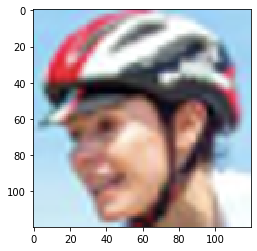

In [191]:
plt.imshow(all_cropped_imgs_v2[1110][1], interpolation='nearest')

In [192]:
# Transforming images in a proper array for model input
cropped_imgs_array = []
for i in range(0, len(all_cropped_imgs_v2)):
    cropped_imgs_array.append(np.array(all_cropped_imgs_v2[i][1]))
    
cropped_imgs_array = np.array(cropped_imgs_array, dtype='int')

# Creating an array with labels
labels_array_cropped = []
for i in range(0, len(all_cropped_imgs_v2)):
    labels_array_cropped.append(np.array(all_cropped_imgs_v2[i][2]))
  
labels_array_cropped = np.array(labels_array_cropped, dtype='int')

# Categorically encode the labels
cropped_imgs_labels = to_categorical(labels_array_cropped)

In [193]:
data_cropped, input_shape_cr = reshape_img_input(x=cropped_imgs_array,
                                         img_rows=120, 
                                         img_cols=120,
                                         normalize=True)

Original shape of nd-array: (1433, 120, 120, 3)


#### Train, Test & Validation split

In [194]:
from sklearn.model_selection import train_test_split
X_train_cr, X_test_1_cr, y_train_cr, y_test_1_cr = train_test_split(data_cropped, cropped_imgs_labels,
                                                    stratify=cropped_imgs_labels, 
                                                    test_size=0.25, random_state=5)

X_test_cr, X_val_cr, y_test_cr, y_val_cr = train_test_split(X_test_1_cr, y_test_1_cr,
                                                    stratify=y_test_1_cr, 
                                                    test_size=0.25, random_state=5)

In [219]:

X_test_cr[1].shape

(120, 120, 3)

### Fitting InceptionV3 on cropped images

In [199]:
inceptv3_cropped = InceptionV3(
    weights = "imagenet",
    input_shape = (120, 120, 3),
    include_top = False 
)

for layer in inceptv3_cropped.layers:
    layer.trainable = False

inputs = Input(shape=(120, 120, 3))
x = inceptv3_cropped(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation='softmax')(x)
inception_v3_cropped = Model(inputs, outputs)

inception_v3_cropped.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [200]:
opt = optimizers.Adam(learning_rate=learning_Rate*10) 
inception_v3_cropped.compile(optimizer = opt,
                        loss = "categorical_crossentropy",
                        metrics = ['accuracy', 'Recall', 'Precision', 'AUC'])

In [307]:
model_cropped = inception_v3_cropped.fit(
                    x = X_train_cr,
                    y = y_train_cr,
                    epochs = num_Epochs,
                    steps_per_epoch = steps_per_Epoch,
                    batch_size = batch_Size,
                    verbose = 1,
                    validation_data = (X_val_cr, y_val_cr),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50
71/71 [==============================] - 33s 463ms/step - loss: 0.8638 - accuracy: 0.8904 - recall: 0.8904 - precision: 0.8904 - auc: 0.9365 - val_loss: 0.2005 - val_accuracy: 0.9222 - val_recall: 0.9222 - val_precision: 0.9222 - val_auc: 0.9790 - lr: 1.0000e-03
Epoch 2/50
71/71 [==============================] - 36s 501ms/step - loss: 0.3380 - accuracy: 0.9234 - recall: 0.9234 - precision: 0.9234 - auc: 0.9701 - val_loss: 0.1716 - val_accuracy: 0.9444 - val_recall: 0.9444 - val_precision: 0.9444 - val_auc: 0.9790 - lr: 1.0000e-03
Epoch 3/50
71/71 [==============================] - 65s 905ms/step - loss: 0.2006 - accuracy: 0.9505 - recall: 0.9505 - precision: 0.9505 - auc: 0.9831 - val_loss: 0.1290 - val_accuracy: 0.9444 - val_recall: 0.9444 - val_precision: 0.9444 - val_auc: 0.9893 - lr: 1.0000e-03
Epoch 4/50
71/71 [==============================] - 50s 715ms/step - loss: 0.1281 - accuracy: 0.9635 - recall: 0.9635 - precision: 0.9635 - auc: 0.9915 - val_loss: 0.0993 - val_a

In [ ]:
loss = model_cropped.history['loss']
val_loss = model_cropped.history['val_loss']
acc = model_cropped.history['accuracy']
val_acc = model_cropped.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_true = np.argmax(y_test_cr, axis = 1)[:]
pred = inception_v3_cropped.predict(X_test_cr, verbose = 0) # Predict prob and get Class Indices
y_pred= np.argmax(pred, axis = 1)[:]

# calculate accuracy
acc = accuracy_score(y_pred[:], y_true[:])

print("InceptionV3 Accuracy on cropped images: {:.2%}".format(acc))

## Testing the Results

### Testing the full images using the best model

In [309]:
#need only as an input a picture

def Detecting_Helmet(i):
	
	image=X_test[i]
	#The bounding box for the labels
	startX=0
	startY=0
	endX=224
	endY=224

	# Run the image through the model to see whether it has a helmet on it or not.
	(WithouthHelmet, Helmet) = CNN_few_Layers.predict(X_test, verbose = 0)[i]

	# Choose a class mark and a color to use for the bounding box and text.
	label = "Helmet" if Helmet > WithouthHelmet else "No Helmet"
	color =  (0,255,0) if label == "Helmet" else (255,0,0)

	# Show the confidence (probability) in the label.
	label = "{}: {:.2f}%".format(label, max(Helmet, WithouthHelmet) * 100)

	# On the output panel, show the mark and bounding box rectangle.
	cv2.putText(image, label, (10, 20),
				cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 1)
				
	cv2.rectangle(image, (startX+5, startY+5), (endX-5, endY-5), color, 2)

	# # Display the final picture
	plt.figure(figsize=(5, 5))  
	plt.axis('off')
	plt.imshow(image)

# Detecting_Helmet(15, )

In [336]:
img = mpimg.imread('C://Users//Eftixia//Desktop//dataset//Final Helmet datasets//Helmet Kaggle//images//BikesHelmets31.png')


def Helmet_Recognition(full_image): #1
	
	#The bounding box for the labels
	startX=0
	startY=0
	endX=224
	endY=224

	# Select the face ROI, adjust the channel ordering from BGR to RGB, and resize it to 120, 120 pixels., and preprocess it
	full_image = full_image[startY:endY, startX:endX]
	full_image = cv2.cvtColor(full_image, cv2.INPAINT_TELEA)
	full_image = cv2.resize(full_image, (240, 240)) #inception_v3_cropped model for cropped has as input 120x120 shape
	full_image = img_to_array(full_image)
	full_image = preprocess_input(full_image)
	full_image = np.expand_dims(full_image, axis=0)

# 	# Run the image through the model to see whether it has a helmet on it or not.
	(WithouthHelmet, Helmet) = CNN_few_Layers.predict(full_image, verbose = 0)[0]

	# Choose a class mark and a color to use for the bounding box and text.
	label = "Helmet" if Helmet > WithouthHelmet else "No Helmet"
	color =  (0,255,0) if label == "Helmet" else (255,0,0)

	# Show the confidence (probability) in the label.
	label = "{}: {:.2f}%".format(label, max(Helmet, WithouthHelmet) * 100)

	# On the output panel, show the mark and bounding box rectangle.
	cv2.putText(full_image, label, (10, 20),
				cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 1)
				
	cv2.rectangle(full_image, (startX+5, startY+5), (endX-5, endY-5), color, 2)

	# # Display the final picture
	plt.figure(figsize=(5, 5))  
	plt.axis('off')
	plt.imshow(full_image)

Helmet_Recognition(img)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/flatten/Reshape' defined at (most recent call last):
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Eftixia\AppData\Local\Temp\ipykernel_10812\1918919975.py", line 18, in <cell line: 18>
      (Helmet, WithouthHelmet) = CNN_few_Layers.predict(reshaped_image)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Eftixia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\reshaping\flatten.py", line 98, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential/flatten/Reshape'
Input to reshape is a tensor with 453152 values, but the requested shape requires a multiple of 394272
	 [[{{node sequential/flatten/Reshape}}]] [Op:__inference_predict_function_5001]

### Detect helmets using bounding box
Once we know where in the image the face is using the boundig box, we can extract the face . And from there, we apply the model for helmet detection, allowing us to predict the

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


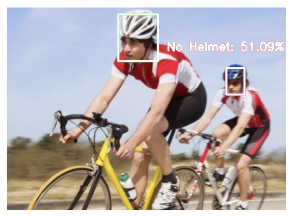

In [328]:
box=[[154,5,221,82],[309,82,345,130]]
img = mpimg.imread('C://Users//Eftixia//Desktop//dataset//Final Helmet datasets//Helmet Kaggle//images//BikesHelmets19.png')

def detect_helmet_image(img,box):
	for i in range(0,len(box)):
		# coordinates (x, y) of the object's bounding box.
		(startX, startY, endX, endY) = box[i]

		# Select the face ROI, adjust the channel ordering from BGR to RGB, and resize it to 120, 120 pixels., and preprocess it
		face = img[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.INPAINT_TELEA)
		face = cv2.resize(face, (120, 120)) #inception_v3_cropped model for cropped has as input 120x120 shape
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		#make the prediction
		inception_v3_cropped.predict(face, verbose = 0)[0]


		# Run the image through the model to see whether it has a helmet on it or not.
		(WithouthHelmet, Helmet) = inception_v3_cropped.predict(face, verbose = 0)[0]

		# Choose a class mark and a color to use for the bounding box and text.
		label = "Helmet" if Helmet > WithouthHelmet else "No Helmet"
		color =  (0,255,0) if label == "Helmet" else (255,0,0)

		# Show the confidence (probability) in the label.
		label = "{}: {:.2f}%".format(label, max(Helmet, WithouthHelmet) * 100)

		# On the output panel, show the mark and bounding box rectangle.
		cv2.putText(img, label, (startX-80, startY - 20),
					cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)
		cv2.rectangle(img, (startX+5, startY+5), (endX-5, endY-5), color, 2)

	# Display the final picture
	plt.figure(figsize=(5, 5))  
	plt.axis('off')
	plt.imshow(img)

detect_helmet_image(img,box)
